# Urban Simulation Assessment code

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from operator import itemgetter
import numpy as np

## Part 1: London's underground resilience

In [42]:
# Reading in the network data
G = nx.read_graphml('london.graph.xml')

In [43]:
# Checking data
print(nx.info(G))
list(G.nodes(data = True))[0]

Graph with 401 nodes and 467 edges


('Wembley Park', {'coords': '(519316.5590174915, 186389.32981656672)'})

In [44]:
# Fixing the data type
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [45]:
# To check node attributes:
list(G.nodes(data = True))[0:3]

[('Wembley Park', {'coords': (519316.5590174915, 186389.32981656672)}),
 ('Kingsbury', {'coords': (519359.9688603217, 188721.22027255083)}),
 ('Queensbury', {'coords': (518811.3613368616, 189760.50737704366)})]

In [46]:
# To check edge attributes:
list(G.edges(data = True))[0:3]

[('Wembley Park',
  'Kingsbury',
  {'length': 2916.7715580506483, 'line_name': 'Jubilee', 'flows': 12356}),
 ('Wembley Park',
  'Neasden',
  {'length': 2353.1659381957816, 'line_name': 'Jubilee', 'flows': 6744}),
 ('Wembley Park',
  'Preston Road',
  {'length': 1419.7351657633037, 'line_name': 'Metropolitan', 'flows': 36601})]

In [178]:
# Add inverse flow:
inv_flows={(e1, e2):(round(1./flows,7) if flows!=0 else 10000) for e1, e2, flows in G.edges(data='flows')}

# Let us add the inversed flows as an attribute to the edges in the graph
nx.set_edge_attributes(G, inv_flows, 'inv_flows')

# Print edge list with attributes
list(G.edges(data = True))[0:3]

[('Wembley Park',
  'Kingsbury',
  {'length': 2916.7715580506483,
   'line_name': 'Jubilee',
   'flows': 12356,
   'inv_flows': 8.09e-05}),
 ('Wembley Park',
  'Neasden',
  {'length': 2353.1659381957816,
   'line_name': 'Jubilee',
   'flows': 6744,
   'inv_flows': 0.0001483}),
 ('Wembley Park',
  'Preston Road',
  {'length': 1419.7351657633037,
   'line_name': 'Metropolitan',
   'flows': 36601,
   'inv_flows': 2.73e-05})]

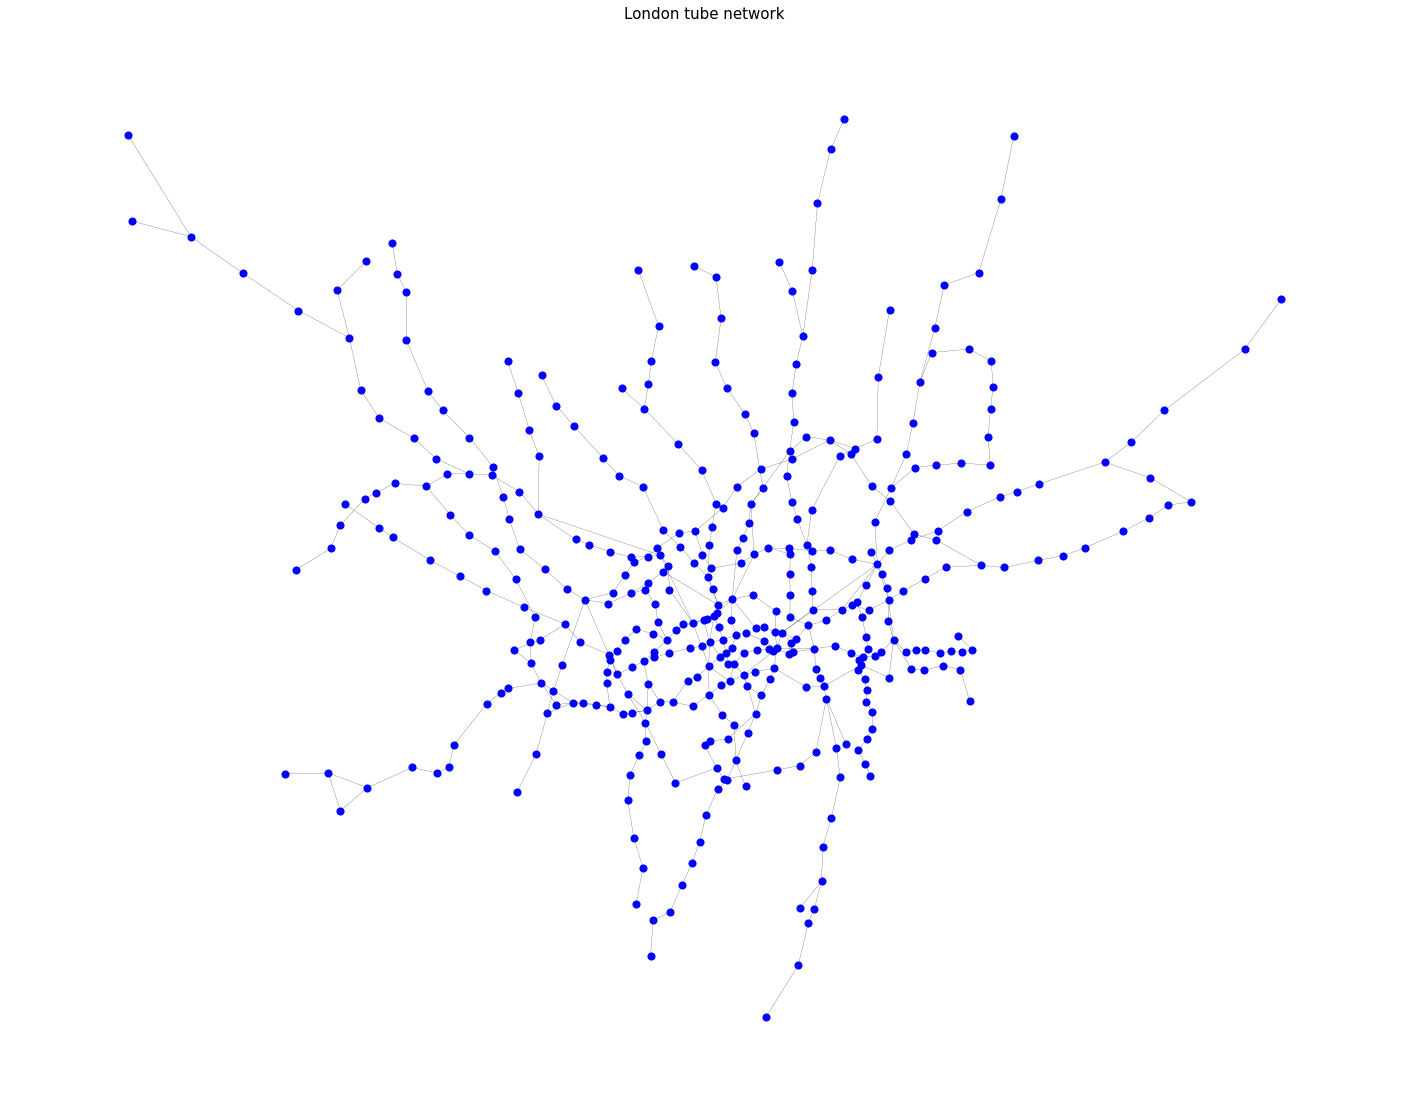

In [47]:
# Final check

#Setting up the positioning
fig, ax = plt.subplots(figsize=(25,20))
pos = nx.get_node_attributes(G, 'coords')
#Setting up the labels
node_labels = nx.get_node_attributes(G, 'station_name')

#Plot
nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

### I. Topological network
This part models London's underground as a topological (unweighted) network

#### I.1. Centrality measures
**Definitions from: Latora and Marchiori - 2007 - A measure of centrality based on network efficiency**
- Measure 1: degree centrality
- Measure 2: (topological) closeness centrality
- Measure 3: (topological) betweenness centrality

| Centrality measure | Definition | Equation for node ${i}$ (normalised) | Meaning for London underground | Importance for London underground
| :- | :- | :-: | :- | :- |
| Degree centrality (DC) | Number of direct ties a node has, normalised by potential neighbour count | ${C}^{D}_{i}=\frac{{k}_{i}}{N-1}$ <br> where ${k}_{i}$ is the number of direct ties| Number of stations directly connected to a node ${i}$ | Higher ${C}^{D}_{i}$ implies that connection between lines occur at that station, so the shut-down of the station likely causes large disruption requiring users to find other ways to switch lines and more lines to adjust their train schedules
| Closeness centrality (CC) | Reciprocal of the average distance from a node to all the other nodes | ${C}^{C}_{i}=\frac{N-1}{\sum{{d}_{ij}}}$ <br> where ${j}\neq{i}$ | How accessible a station is to all the rest of the stations, defined by the shortest path length | Higher ${C}^{C}_{i}$ implies that the station is easily accessible and therefore well-located for living and work, so the shut-down of the station likely causes inconvenience directly to a large number of people who aim to reach this station, having to find alternative routes
| Betweenness centrality (BC) | Number of geodesic linking two other nodes passing through a node ${i}$, normalised by the number of geodesic path in the network | ${C}^{B}_{i}=\frac{\sum{\sum{{n}_{jk}({i})}/{n}_{jk}}}{(N-1)(N-2)}$ <br> where ${j}\neq{i}$ and ${k}\neq{i}$, ${k}\neq{j}$ | How likely users go through this station when trying to reach a station from another, asuming equal probability for all stations to be the origin and destination | Higher ${C}^{B}_{i}$ implies higher chance of the station usage when trying to get from one station to another, so the shut-down of the station likely require more travels to opt for less efficient travel routes

*Table 1. Centrality measure summary, where ${N}$ is the total node count in London underground*

In [48]:
# Computing each measures - degree centrality
degree_dict =nx.degree_centrality(G)
nx.set_node_attributes(G,dict(degree_dict),'degree')

In [49]:
# Computing each measures - closeness centrality
closeness_t_dict =nx.closeness_centrality(G)
nx.set_node_attributes(G,dict(closeness_t_dict),'closeness_t')

In [50]:
# Computing each measures - betweenness centrality
betweenness_t_dict =nx.betweenness_centrality(G)
nx.set_node_attributes(G,dict(betweenness_t_dict),'betweenness_t')

In [51]:
# Creating a dataframe with station name and 3 centrality measures
df = pd.DataFrame()
df['station_name'] = G.nodes()
df['degree'] = pd.Series(nx.get_node_attributes(G, 'degree'))
df['topological closeness'] = pd.Series(nx.get_node_attributes(G, 'closeness_t'))
df['topological betweenness'] = pd.Series(nx.get_node_attributes(G, 'betweenness_t'))

In [60]:
# Check the top 10 for degree centrality
df_sorted_deg = df.sort_values(["degree"], ascending=False)
df_sorted_deg[['station_name', 'degree']][0:11]

,station_name,degree
Stratford,Stratford,0.0225
Bank and Monument,Bank and Monument,0.0200
King's Cross St. Pancras,King's Cross St. Pancras,0.0175
Baker Street,Baker Street,0.0175
Earl's Court,Earl's Court,0.0150
Oxford Circus,Oxford Circus,0.0150
Liverpool Street,Liverpool Street,0.0150
Waterloo,Waterloo,0.0150
Green Park,Green Park,0.0150
Canning Town,Canning Town,0.0150


In [59]:
# Check the top 10 for topological closeness centrality
df_sorted_clos = df.sort_values(["topological closeness"], ascending=False)
df_sorted_clos[['station_name', 'topological closeness']][0:10]

,station_name,topological closeness
Green Park,Green Park,0.114778
Bank and Monument,Bank and Monument,0.113572
King's Cross St. Pancras,King's Cross St. Pancras,0.113443
Westminster,Westminster,0.112549
Waterloo,Waterloo,0.112265
Oxford Circus,Oxford Circus,0.111204
Bond Street,Bond Street,0.110988
Farringdon,Farringdon,0.110742
Angel,Angel,0.110742
Moorgate,Moorgate,0.110314


In [71]:
# Check the top 10 for topological closeness centrality
df_sorted_bet = df.sort_values(["topological betweenness"], ascending=False)
df_sorted_bet[0:10]

,station_name,degree,topological closeness,topological betweenness
Stratford,Stratford,0.0225,0.104384,0.297846
Bank and Monument,Bank and Monument,0.0200,0.113572,0.290489
Liverpool Street,Liverpool Street,0.0150,0.110254,0.270807
King's Cross St. Pancras,King's Cross St. Pancras,0.0175,0.113443,0.255307
Waterloo,Waterloo,0.0150,0.112265,0.243921
Green Park,Green Park,0.0150,0.114778,0.215835
Euston,Euston,0.0125,0.109830,0.208324
Westminster,Westminster,0.0100,0.112549,0.203335
Baker Street,Baker Street,0.0175,0.108962,0.191568
Finchley Road,Finchley Road,0.0100,0.102617,0.165085


##### Output table:

| Rank | Degree centrality || Closeness centrality || Betweenness centrality ||
| -: | -: | :- | -: | :- | -: | :- |
| <b>1</b> | Stratford | 0.0225 | Green Park | 0.1148 | Stratford | 0.2978 |
| <b>2</b> | Bank and Monument  | 0.0200 | Bank and Monument | 0.1136 | Bank and Monument | 0.2905 |
| <b>3</b> | King's Cross St. Pancras | 0.0175 | King's Cross St. Pancras | 0.1134 | Liverpool Street | 0.2708 |
| <b>4</b> | Baker Street | 0.0175 | Westminster | 0.1125 | King's Cross St. Pancras | 0.2553 |
| <b>5</b> | Earl's Court | 0.0150 | Waterloo | 0.1123 | Waterloo | 0.2439 |
| <b>6</b> | Oxford Circus | 0.0150 | Oxford Circus | 0.1112 | Gren Park |0.2158 |
| <b>7</b> | Liverpool Street | 0.0150 | Bond Street | 0.1110 | Euston | 0.2083 |
| <b>8</b> | Waterloo | 0.0150 | Farringdon | 0.1107 | Westminster | 0.2033 |
| <b>9</b> | Green Park | 0.0150 | Angel | 0.1107 | Baker Street | 0.1916 |
| <b>10</b> | Canning Town | 0.0150 | Moorgate | 0.1103 | Finchley Road | 0.1651 |
| <b>11</b> | West Ham | 0.0150 | - | - | - | - |

*Table 2. Centrality measure computed results*

#### I.2. Impact measures - refer to word doc

(Removed -->)
<!--
**Definitions from: Efficiency measure_Latora and Marchiori (2001)_Efficient Behavior of Small-World Networks**
- Measure 1: Local efficiency - returns the average local efficiency of the graph. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.local_efficiency.html#networkx.algorithms.efficiency_measures.local_efficiency
- Measure 2: Global efficiency - returns the average global efficiency of the graph. https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.efficiency_measures.global_efficiency.html#networkx.algorithms.efficiency_measures.global_efficiency
-->

In [205]:
'''
def global_efficiency_weighted(G):
    n = len(G)
    d_sum = 0
    denom = n * (n - 1)
    #shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = 'inv_flows'))
    shortest_paths = list(nx.all_pairs_dijkstra_path_length(G, weight = None))

    for u in range(0, n):
        for key in shortest_paths[u][1]:
            d_sum = d_sum + (1/shortest_paths[u][1][key] if shortest_paths[u][1][key] !=0 else 0)
    
    g_eff = d_sum/ denom
    return g_eff
'''

#### I.3. Node removal

In [272]:
def maxsize_comp(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    return G_maxsub.number_of_nodes()

In [274]:
def avg_length(G):
    components = nx.connected_components(G)
    
    # Create a "subgraph" of the largest component
    largest_component = max(components, key=len)
    G_maxsub = G.subgraph(largest_component)
    
    return nx.average_shortest_path_length(G_maxsub)

In [291]:
# centrality: 'degree', 'closeness_t', or 'betweenness_t'
def node_removal(centrality:str, sequential: bool)->tuple:

    # Initialise the output dataframe
    df_sub = []
    
    # Copy the graph for this
    G_rm = G.copy()

    # Initiate a list to store impact measures
    list_num_comp = []
    list_maxsize_comp = []
    list_avg_length = []
    list_avg_length_per_node = []

    # Initial impact measures
    list_num_comp.append(nx.number_connected_components(G_rm))
    list_maxsize_comp.append(maxsize_comp(G_rm))
    list_avg_length.append(avg_length(G_rm))
    list_avg_length_per_node.append(avg_length(G_rm)/maxsize_comp(G_rm))

    # Loop - repeat for 10 nodes
    for i in range(10):

        if sequential: # Re-calculate centrality
            degree_dict =nx.degree_centrality(G_rm)
            closeness_t_dict =nx.closeness_centrality(G_rm)
            betweenness_t_dict =nx.betweenness_centrality(G_rm)
            nx.set_node_attributes(G_rm,dict(degree_dict),'degree')
            nx.set_node_attributes(G_rm,dict(closeness_t_dict),'closeness_t')
            nx.set_node_attributes(G_rm,dict(betweenness_t_dict),'betweenness_t')
            #print("centrality re-calculated")
            
        # Identify the max centrality node(s)
        centrality_list=[(i[1][centrality]) for i in G_rm.nodes(data=True)]
        max_node=[n for n in G_rm.nodes() if G_rm.nodes[n][centrality] == max(centrality_list)][0] # If multiple max centrality nodes, choose one
        station_name = [key for key, value in G_rm.nodes(data=True) if G_rm.nodes[key][centrality] == max(centrality_list)][0]
        #print("max centrality to be removed:", max(centrality_list))
        #print("node name to be removed:", station_name)
            
        # Remove the node
        G_rm.remove_node(max_node)

        # Evaluate the network efficiency
        list_num_comp.append(nx.number_connected_components(G_rm))
        list_maxsize_comp.append(maxsize_comp(G_rm))
        list_avg_length.append(avg_length(G_rm))
        list_avg_length_per_node.append(avg_length(G_rm)/maxsize_comp(G_rm))
    
    print('Number of components in the graph: ', list_num_comp)
    print('Number of nodes in the largest component: ', list_maxsize_comp) 
    print('Average shortest path of the largest component: ', list_avg_length)
    print('Average shortest path per node of the largest component: ', list_avg_length_per_node)
    
    # Adding the results to the output dataframe
    df_sub = pd.DataFrame(zip(list_num_comp, list_maxsize_comp, list_avg_length, list_avg_length_per_node), 
                          columns = ['#components', 'maxsize', 'avlength', 'avlength per node'])
        
    return(df_sub)
    

#### Strategy A: non-sequential removal of 10 most impoartant nodes (one by one)

Degree centrality

In [300]:
df_degree_A = node_removal('degree', False)
#df_degree_A

Number of components in the graph:  [1, 3, 3, 3, 4, 5, 8, 8, 8, 9, 10]
Number of nodes in the largest component:  [401, 379, 378, 377, 374, 371, 356, 355, 354, 352, 346]
Average shortest path of the largest component:  [13.545997506234414, 14.496447069006436, 14.872496596634528, 15.686438286585021, 17.013376152313228, 17.853835506665696, 17.69335337869916, 18.139508235855814, 18.344520734303227, 18.419159544159545, 18.40477506911284]
Average shortest path per node of the largest component:  [0.03378054240956213, 0.03824920070977952, 0.03934522909162574, 0.041608589619588916, 0.04549031056768243, 0.04812354584006926, 0.04970043083904259, 0.05109720629818539, 0.0518206800404046, 0.0523271577959078, 0.053192991529227865]


Closeness centrality

In [286]:
df_closeness_A = node_removal('closeness_t', False)
#df_closeness_A

Number of components in the graph:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]
Number of nodes in the largest component:  [401, 400, 399, 398, 397, 396, 395, 394, 393, 392, 389]
Average shortest path of the largest component:  [13.545997506234414, 13.82453634085213, 14.382728177226987, 15.98377276812273, 16.080248327099714, 16.855721774709117, 17.43183190901497, 17.464266800997144, 17.462494157968532, 17.460527689336605, 17.47392203111335]
Average shortest path per node of the largest component:  [0.03378054240956213, 0.03456134085213033, 0.03604693778753631, 0.040160233085735506, 0.04050440384659877, 0.04256495397653817, 0.04413122002282271, 0.04432555025633793, 0.04443382737396573, 0.044542162472797464, 0.04492010804913458]


Betweenness centrality

In [287]:
df_betweenness_A = node_removal('betweenness_t', False)
#df_betweenness_A

Number of components in the graph:  [1, 3, 3, 3, 4, 4, 4, 5, 5, 6, 7]
Number of nodes in the largest component:  [401, 379, 378, 377, 371, 370, 369, 346, 345, 342, 339]
Average shortest path of the largest component:  [13.545997506234414, 14.496447069006436, 14.872496596634528, 15.03120943619843, 16.030742332629124, 16.75674210796162, 17.18086485212678, 16.80737203652509, 16.97505898213684, 17.5863387697004, 17.986978757571]
Average shortest path per node of the largest component:  [0.03378054240956213, 0.03824920070977952, 0.03934522909162574, 0.039870582058881776, 0.04320954806638578, 0.04528849218368006, 0.04656060935535713, 0.04857621975874304, 0.04920306951344012, 0.05142204318625848, 0.05305893438811504]


#### Strategy B: Sequential removal of the most important node -> repeat (at least for two nodes)

Degree centrality

In [292]:
df_degree_B = node_removal('degree', True)
#df_degree_B

Number of components in the graph:  [1, 3, 3, 3, 4, 6, 6, 6, 6, 7, 8]
Number of nodes in the largest component:  [401, 379, 378, 377, 374, 360, 359, 358, 357, 355, 341]
Average shortest path of the largest component:  [13.545997506234414, 14.496447069006436, 14.872496596634528, 15.686438286585021, 17.013376152313228, 17.37607551841535, 17.531099733897697, 17.894731076788258, 18.493500771094954, 18.5749661812684, 21.207348628601]
Average shortest path per node of the largest component:  [0.03378054240956213, 0.03824920070977952, 0.03934522909162574, 0.041608589619588916, 0.04549031056768243, 0.04826687644004264, 0.04883314689107994, 0.049985282337397366, 0.051802523168333205, 0.05232384839793916, 0.06219163820704106]


Closeness centrality

In [293]:
df_closeness_B = node_removal('closeness_t', True)
#df_closeness_B

Number of components in the graph:  [1, 1, 1, 1, 1, 1, 2, 4, 4, 5, 5]
Number of nodes in the largest component:  [401, 400, 399, 398, 397, 396, 226, 226, 225, 195, 194]
Average shortest path of the largest component:  [13.545997506234414, 13.82453634085213, 14.65848037178373, 15.114818424616786, 16.70242729562629, 18.974696330392533, 13.978013765978368, 13.978013765978368, 14.729722222222222, 14.747607718741738, 15.661877036483094]
Average shortest path per node of the largest component:  [0.03378054240956213, 0.03456134085213033, 0.03673804604457075, 0.037976930715117554, 0.042071605278655645, 0.04791589982422357, 0.0618496184335326, 0.0618496184335326, 0.06546543209876543, 0.07562875753200891, 0.08073132493032523]


Betweenness centrality

In [294]:
df_betweenness_B = node_removal('betweenness_t', True)
#df_betweenness_B

Number of components in the graph:  [1, 3, 3, 3, 3, 3, 4, 4, 5, 6, 7]
Number of nodes in the largest component:  [401, 379, 378, 377, 376, 375, 227, 226, 196, 173, 170]
Average shortest path of the largest component:  [13.545997506234414, 14.496447069006436, 15.31013431013431, 15.795939387098596, 16.789631205673757, 19.02923351158645, 13.4623601419048, 14.20645034414946, 13.792046049188906, 13.821884661916924, 18.193595544726765]
Average shortest path per node of the largest component:  [0.03378054240956213, 0.03824920070977952, 0.04050300082046114, 0.041899043467105025, 0.04465327448317489, 0.05074462269756387, 0.05930555128592423, 0.06286039975287372, 0.07036758188361687, 0.0798952870631036, 0.10702115026309862]


#### A&B. Plot the results on the same plot

In [295]:
df_degree_A.head()

,#components,maxsize,avlength,avlength per node
0,1,401,13.545998,0.033781
1,3,379,14.496447,0.038249
2,3,378,14.872497,0.039345
3,3,377,15.686438,0.041609
4,4,374,17.013376,0.045490


In [301]:
# normalise all dataframes
dfs = [df_degree_A, df_degree_B, df_closeness_A, df_closeness_B, df_betweenness_A, df_betweenness_B]

for df in dfs:
    for column in df:
        df[column + '_normed'] = df[column]/df[column][0]

##### Graph

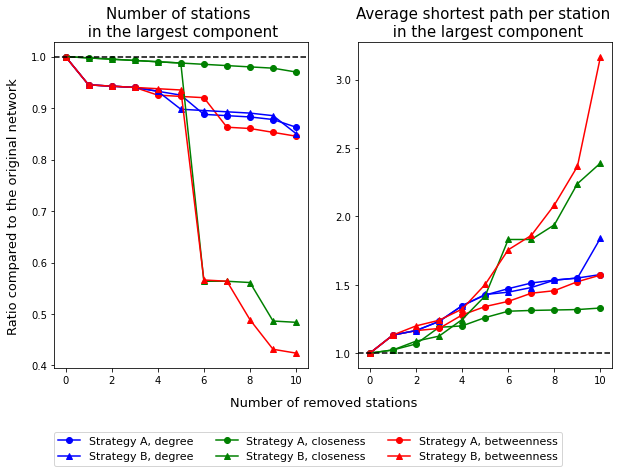

In [426]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (10,6))
text = fig.supxlabel('Number of removed stations', y=0.03, fontsize = '13')
text2 = fig.supylabel('Ratio compared to the original network', x=0.06, fontsize = '13')

# 1st subplot
axes[0].set_title('Number of stations \n in the largest component',fontsize = '15')
axes[0].plot(df_degree_A['maxsize_normed'],'-bo', label='Strategy A, degree')
axes[0].plot(df_closeness_A['maxsize_normed'],'-go', label='Strategy A, closeness')
axes[0].plot(df_betweenness_A['maxsize_normed'],'-ro', label='Strategy A, betweenness')
axes[0].plot(df_degree_B['maxsize_normed'],'-b^', label='Strategy B, degree')
axes[0].plot(df_closeness_B['maxsize_normed'],'-g^', label='Strategy B, closeness')
axes[0].plot(df_betweenness_B['maxsize_normed'],'-r^', label='Strategy B, betweenness')
axes[0].axhline(1, linestyle='--', color = 'k')

# 2nd subplot
axes[1].set_title('Average shortest path per station \n in the largest component',fontsize = '15')
axes[1].plot(df_degree_A['avlength per node_normed'],'-bo', label='Strategy A, degree')
axes[1].plot(df_closeness_A['avlength per node_normed'],'-go', label='Strategy A, closeness')
axes[1].plot(df_betweenness_A['avlength per node_normed'],'-ro', label='Strategy A, betweenness')
axes[1].plot(df_degree_B['avlength per node_normed'],'-b^', label='Strategy B, degree')
axes[1].plot(df_closeness_B['avlength per node_normed'],'-g^', label='Strategy B, closeness')
axes[1].plot(df_betweenness_B['avlength per node_normed'],'-r^', label='Strategy B, betweenness')
axes[1].axhline(1, linestyle='--', color = 'k')

# legend
handles, labels = axes[1].get_legend_handles_labels()
order = [0,3,1,4,2,5]
#add legend to plot
legend = axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                       loc=(-1.2, -0.3), ncol=3, fontsize = '11')

fig.savefig('Part 1I Impact calc', bbox_extra_artists=(legend,text,text2), bbox_inches='tight')

### II. Flows: weighted network

## Part 2: Spatial interaction models

In [ ]:
# Reading in the OD matrix
df_OD_long = pd.read_csv("OD_london.csv", index_col=0)

In [ ]:
# Creating a pivot table from the long list
df_OD = pd.pivot_table(df_OD_long, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)

In [ ]:
# Remove entries where orig = dest
df_OD = df_OD.loc[cdata["OrigCode"] != cdata["DestCode"]]

### III. Models and calibration

In [ ]:
# Fitting the model
def model_predict(dataframe, formula):

    #run a model
    model = smf.glm(formula, data=dataframe, family=sm.families.Poisson()).fit()
    predictions = model.get_prediction()
    predictions_summary_frame = predictions.summary_frame()
    
    dataframe[formula] = predictions_summary_frame["mean"]
    
    #round and convert to integers
    dataframe[formula] = round(dataframe[formula], 0)
    dataframe[formula] = dataframe[formula].astype(int)
    
    '''
    #show the results as a pivot table
    pivot_table = dataframe.pivot_table(values =formula, index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
    print(pivot_table)
    '''

    #calculate the metric
    Rsq = CalcRSqaured(cdata["Total"], cdata[formula])
    RMSE = CalcRMSE(cdata["Total"], cdata[formula])
    
#    return (sum(dataframe[formula]), Rsq, RMSE)
    return (sum(dataframe[formula]), Rsq, RMSE, model.summary())

### IV. Scenarios